In [3]:
# Import libraries
import pandas as pd
import sys, os
import matplotlib.pyplot as plt

import folium
from folium import plugins

from wordcloud import WordCloud, STOPWORDS

In [4]:
# Function for output csv file
pd.options.mode.copy_on_write = True


def data_exploration(df_combined, months_folders, output_csv_path, columns_to_select):

    # Number of NaN values replaced
    nan_replaced_count = 0

    # For each month
    for month_folder in months_folders:
        # Start by importing "listings.csv"
        input_csv_path = os.path.join(month_folder, 'listings.csv')
        
        # The dataframe
        df = pd.read_csv(input_csv_path, low_memory=False)
        
        # Include only the columns that we want and are in the .csv file
        columns_to_keep = [col for col in columns_to_select if col in df.columns]
        df_selected = df[columns_to_keep]
        
        # Columns from other .csv files
        additional_columns = set()
        
        # Check all other .csv files in the folder
        for filename in os.listdir(month_folder):
            if filename.endswith('.csv') and filename != 'listings.csv':  # We want .csv files but no the starting one, aka "listings.csv"
                file_path = os.path.join(month_folder, filename)
                other_df = pd.read_csv(file_path)

                # Iterate over each column
                for col in other_df.columns:
                    # If we find a column that we want but is not already in our dataframe, add it from the other .csv file
                    if col not in df_selected.columns and col in columns_to_select:
                        additional_columns.add(col)
                        # Add the column and its data to our dataframe
                        df_selected[col] = other_df[col]

                    elif  col in df_selected.columns and col in columns_to_select:
                        # Check if any value of the column in our dataframe is NaN
                        nan_mask = df_selected[col].isna()
                        
                        # Check if the corresponding value in the other dataframes is not NaN
                        non_nan_mask = ~other_df[col].isna()
                        
                        # Replace NaN values with not NaN ones
                        df_selected.loc[nan_mask & non_nan_mask, col] = other_df.loc[nan_mask & non_nan_mask, col]
                        # print(f"NaN values in column '{col}' replaced with non-NaN values.")

                        # Number of NaN values replaced
                        nan_replaced_count += sum(nan_mask & non_nan_mask)

        # Concatenate every months dataframes
        df_combined = pd.concat([df_combined, df_selected], ignore_index=True)

    # Write the final dataframe to the output .csv file
    df_combined.to_csv(output_csv_path, index=False)

    print(f"Data from all months has been written to {output_csv_path}")
    print(f"The output CSV file has {df_selected.shape[1]} columns.")
    # print("Columns added to the output file:")
    # for col in df_selected.columns:
    #    print(col)
    print(f"Number of NaN values replaced: {nan_replaced_count}")

    return df_combined

# Initialize a DataFrame to store data for 2019
df_combined_2019 = pd.DataFrame()

# Initialize a DataFrame to store data for 2023
df_combined_2023 = pd.DataFrame()

# Columns we want to select
columns_to_select_2019 = ['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews',
                        'neighbourhood', 'name', 'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since',
                        'host_response_rate','host_identity_verified', 'host_has_profile_pic', 'first_review', 'description','city',
                        'cancellation_policy', 'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type',
                        'property_type', 'price', 'availability_365', 'minimum_nights', 'last_scraped', 'comments', 'host_id', 'host_name']

columns_to_select_2023 = ['id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews',
                        'neighbourhood_cleansed', 'name', 'latitude', 'longitude', 'last_review', 'instant_bookable', 'host_since',
                        'host_response_rate','host_identity_verified', 'host_has_profile_pic', 'first_review', 'description','city',
                        'cancellation_policy', 'bed_type', 'bathrooms', 'accommodates', 'amenities', 'room_type',
                        'property_type', 'price', 'availability_365', 'minimum_nights', 'last_scraped', 'comments', 'host_id', 'host_name']

### 2019 ###

# Each month's folder
months_folders = ['data/2019/april', 'data/2019/febrouary', 'data/2019/march']

# Path to the output CSV file
output_csv_path_2019 = 'data_train/train_2019.csv'

print("For 2019:")
df_combined_2019 = data_exploration(df_combined_2019, months_folders, output_csv_path_2019, columns_to_select_2019)

### 2023 ###

# Each month's folder
months_folders = ['data/2023/june', 'data/2023/march', 'data/2023/september']

# Path to the output CSV file
output_csv_path_2023 = 'data_train/train_2023.csv'

print("\nFor 2023:")
df_combined_2023 = data_exploration(df_combined_2023, months_folders, output_csv_path_2023, columns_to_select_2023)
df_combined_2023.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

For 2019:
Data from all months has been written to data_train/train_2019.csv
The output CSV file has 34 columns.
Number of NaN values replaced: 261

For 2023:
Data from all months has been written to data_train/train_2023.csv
The output CSV file has 29 columns.
Number of NaN values replaced: 4117


In [6]:
# data cleaning 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def cleaning_data(df, output_csv_path):
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ', 'Plaka')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ', 'Attiki')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ', 'Exarcheia')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ','Agios Konstantinos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΥΨΕΛΗ', 'Kypseli')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΑΓΚΡΑΤΙ', 'Pangrati')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΝΕΟΣ ΚΟΣΜΟΣ', 'Neos Kosmos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΟΛΩΝΑΚΙ', 'Kolonaki')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΜΠΕΛΟΚΗΠΟΙ', 'Ambelokipi')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ', 'Koukaki')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΕΡΑΜΕΙΚΟΣ', 'Kerameikos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΣΤΑΔΙΟ', 'Stadio')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΚΡΟΠΟΛΗ', 'Akropoli')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΛΥΚΑΒΗΤΤΟΣ', 'Lykavittos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΕΝΤΑΓΩΝΟ', 'Pedagono')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ', 'Akadimia Platonos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΘΗΣΕΙΟ', 'Thiseio')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΓΟΥΒΑ', 'Gouva')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΓΟΥΔΙ', 'Goudi')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΕΔΙΟ ΑΡΕΩΣ', 'Pedion Areos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΝΩ ΠΑΤΗΣΙΑ', 'Patisia')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΟΛΩΝΟΣ', 'Kolonos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΝΙΡΒΑΝΑ', 'Nirvana')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΕΛΛΗΝΟΡΩΣΩΝ', 'Ellinoroson')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΙΛΙΣΙΑ', 'Ilisia')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΖΑΠΠΕΙΟ', 'Zappeio')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΓΚΥΖΗ', 'Gizi')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΒΟΤΑΝΙΚΟΣ', 'Votanikos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ', 'Agios Nikolaos')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΕΤΡΑΛΩΝΑ', 'Petralona')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΓΚΑΖΙ', 'Gazi')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('1Ο ΝΕΚΡΟΤΑΦΕΙΟ', '1o Nekrotafio')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΑΤΗΣΙΑ', 'Patisia')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΡΟΜΠΟΝΑ', 'Probona')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΟΛΥΓΩΝΟ', 'Poligono')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ','Agios Eleftherios')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ', 'Plateia Amerikis')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΚΟΛΟΚΥΝΘΟΥ', 'Kolokinthou')
    
    # specifically for 2023
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΑΝΩ ', '')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΣΤΑΘΜΟΣ ΛΑΡΙΣΗΣ', 'Stathmos Larisis')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΝΕΑ ', '')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΣΕΠΟΛΙΑ', 'Sepolia')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΡΙΖΟΥΠΟΛΗ', 'Rizoupoli')
    df['neighbourhood'] = df['neighbourhood'].astype(str).str.replace('ΡΗΓΙΛΛΗΣ', 'Rigilis')

    # general cleaning
    df['last_scraped'] = pd.to_datetime(df['last_scraped'])
    # Extract month from date
    df['month'] = df['last_scraped'].dt.month.astype('category')
    # Clean the 'price' column by removing commas and dollar signs
    df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')

    # Convert the 'price' column to float
    df['price'] = df['price'].astype(float)
    
    df.to_csv(output_csv_path, index=False)

# Clean 2019
cleaning_data(df_combined_2019, output_csv_path_2019)

# Clean 2023
cleaning_data(df_combined_2023, output_csv_path_2023)

# neighborhood_counts = df_combined_2023['neighbourhood'].value_counts()
# print(neighborhood_counts)

In [4]:
# Just to check for different values accross files 
# Define the list of file paths with directory prefix
file_paths = ['data/2023/june/listings.csv', 'data/2023/june/listings0.csv', 'data/2023/june/reviews.csv', ]

# Define the columns to check (excluding 'id')
columns_to_check = ['price', 'minimum_nights', 'zipcode', 'transit', 'cancellation_policy', 'bedrooms', 'beds',
                    'review_scores_rating', 'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude',
                    'last_review', 'instant_bookable', 'host_since', 'host_response_rate', 'host_identity_verified',
                    'host_has_profile_pic', 'first_review', 'description', 'city', 'bed_type', 'bathrooms',
                    'accommodates', 'amenities', 'room_type', 'property_type', 'availability_365']

# Read the data from each file into a dictionary of DataFrames
dfs = {}
for file_path in file_paths:
    df_name = file_path.split('/')[-1].split('.')[0]  # Extracting DataFrame name from file path
    dfs[df_name] = pd.read_csv(file_path)

# Initialize a list to store inconsistencies
inconsistencies = []

# Helper function to normalize value for comparison
def normalize_value(value):
    if isinstance(value, str):
        value = value.strip()  # Remove leading/trailing whitespaces for strings
        if value.startswith('$'):
            value = value[1:]  # Remove leading currency symbol
        if '.' in value:
            value = value.rstrip('0').rstrip('.')  # Remove trailing zeros and decimal point
        return value
    elif isinstance(value, float):
        return round(value, 2)  # Round float values to 2 decimal places
    else:
        return value  # Return other types unchanged

# Iterate over the 'id' column in the 'listings.csv' DataFrame
for idx, row in dfs['listings'].iterrows():
    listing_id = row['id']  # Get the id from 'listings.csv'
    # Iterate over other DataFrames to check corresponding values for this id
    for df_name, df in dfs.items():
        if df_name != 'listings':  # Exclude 'listings.csv' itself
            # Check if the id exists in the current DataFrame
            if 'id' in df.columns and listing_id in df['id'].values:
                # Get the row with the matching id
                matching_row = df[df['id'] == listing_id].iloc[0]
                # Compare values of columns_to_check
                for column in columns_to_check:
                    if column in row and column in matching_row:
                        value1 = normalize_value(row[column])
                        value2 = normalize_value(matching_row[column])
                        if value1 != value2:
                            # Append the inconsistency to the list
                            inconsistencies.append((listing_id, column, df_name, value1, value2))

# Print any inconsistencies found
if inconsistencies:
    print("Inconsistencies found:")
    for inconsistency in inconsistencies:
        print(f"ID: {inconsistency[0]}, Column: {inconsistency[1]}, File: {inconsistency[2]}")
        print(f"  Value in listings.csv: {inconsistency[3]}")
        print(f"  Value in {inconsistency[2]}: {inconsistency[4]}")
else:
    print("No inconsistencies found.")


Inconsistencies found:
ID: 10595, Column: price, File: listings0
  Value in listings.csv: 200
  Value in listings0: 200
ID: 10595, Column: neighbourhood, File: listings0
  Value in listings.csv: Athens, Attica, Greece
  Value in listings0: ΑΜΠΕΛΟΚΗΠΟΙ
ID: 10990, Column: price, File: listings0
  Value in listings.csv: 70
  Value in listings0: 70
ID: 10990, Column: neighbourhood, File: listings0
  Value in listings.csv: Athens, Attica, Greece
  Value in listings0: ΑΜΠΕΛΟΚΗΠΟΙ
ID: 10993, Column: price, File: listings0
  Value in listings.csv: 64
  Value in listings0: 64
ID: 10993, Column: neighbourhood, File: listings0
  Value in listings.csv: Athens, Attica, Greece
  Value in listings0: ΑΜΠΕΛΟΚΗΠΟΙ
ID: 10995, Column: price, File: listings0
  Value in listings.csv: 77
  Value in listings0: 77
ID: 10995, Column: neighbourhood, File: listings0
  Value in listings.csv: Athens, Attica, Greece
  Value in listings0: ΑΜΠΕΛΟΚΗΠΟΙ
ID: 695173, Column: price, File: listings0
  Value in listings.csv:

In [5]:
# Question 1.1

# Function that returns the most common room type of a year
def most_common_room_type(df):
    result = df['room_type'].value_counts().idxmax()
    return result

# Year 2019
room_type = most_common_room_type(df_combined_2019)
print("For 2019 the most common room type is:")
print(room_type)

# Year 2023
room_type = most_common_room_type(df_combined_2023)
print("\nFor 2023 the most common room type is:")
print(room_type)

For 2019 the most common room type is:
Entire home/apt

For 2023 the most common room type is:
Entire home/apt


For 2019 the average price over 3 months is


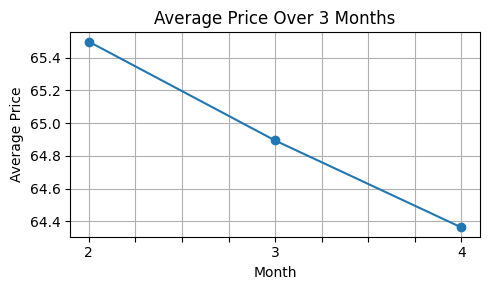


For 2023 the average price over 3 months is:


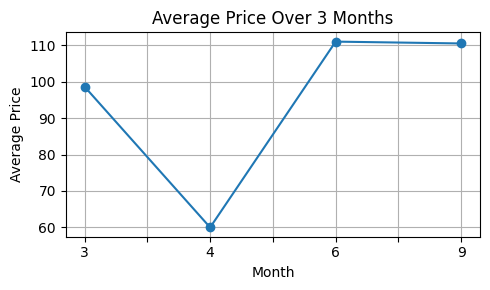

In [6]:
# Question 1.2

def average_price(df, output_csv_path):

    # Group by month and calculate average price
    monthly_avg_price = df.groupby('month', observed=False)['price'].mean()

    # Plotting
    plt.figure(figsize=(5, 3))
    monthly_avg_price.plot(marker='o', linestyle='-')

    # Set labels and title
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.title('Average Price Over 3 Months')

    # Show grid
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

    df.to_csv(output_csv_path, index=False)

# Year 2019
print("For 2019 the average price over 3 months is")
average_price(df_combined_2019, output_csv_path_2019)

# Year 2023
print("\nFor 2023 the average price over 3 months is:")
average_price(df_combined_2023, output_csv_path_2023)

In [7]:
# Question 1.3

def top_neighbourhoods(df):
    neighbourhood_reviews = df.groupby('neighbourhood')['number_of_reviews'].sum()

    neighbourhood_reviews_sorted = neighbourhood_reviews.sort_values(ascending=False)

    # Select the top 5 neighbourhoods
    top_5_neighbourhoods = neighbourhood_reviews_sorted.head()

    # Print the result
    print(top_5_neighbourhoods)

# Year 2019
print("Top 5 neighbourhoods for the year 2019:")
top_neighbourhoods(df_combined_2019)

# Year 2023
print("\nTop 5 neighbourhoods for the year 2023:")
top_neighbourhoods(df_combined_2023)



Top 5 neighbourhoods for the year 2019:
neighbourhood
Plaka           134004
Koukaki          90619
Neos Kosmos      83769
Psyri            54353
Metaxourgeio     44792
Name: number_of_reviews, dtype: int64

Top 5 neighbourhoods for the year 2023:
neighbourhood
Plaka                 433513
Koukaki               207147
Neos Kosmos           129434
Exarcheia             103904
Agios Konstantinos    102836
Name: number_of_reviews, dtype: int64


In [8]:
# Question 1.4

def find_neighbourhood(df):

    temp_df = df.copy()

    temp_df.drop_duplicates(subset=['id'], inplace = True)
    properties = temp_df.groupby(['neighbourhood','month'], observed=False)['id'].count()

    neighborhood_total_counts = properties.groupby('neighbourhood').sum()

    max_property = neighborhood_total_counts.idxmax()
    max_number = neighborhood_total_counts.max()
    print(max_property,max_number)

# Year 2019
print("The neighbourhood with the most properties for 2019:")
find_neighbourhood(df_combined_2019)

# Year 2023
print("\nThe neighbourhood with the most properties for 2023:")
find_neighbourhood(df_combined_2023)

The neighbourhood with the most properties for 2019:
Plaka 1178

The neighbourhood with the most properties for 2023:
Plaka 2647


In [8]:
# Question 1.5

def find_registrations(df):

    temp_df = df.copy()

    temp_df.drop_duplicates(subset=['id'], inplace = True)
    neighborhood_month_counts = temp_df.groupby(['neighbourhood', 'month'], observed=False)['id'].count()
    neighborhood_total_counts = neighborhood_month_counts.groupby('neighbourhood', observed=False).sum()
    #kataxoriseis ana geitonia(diaforetikes mallon?) 
    print(neighborhood_total_counts)

    neighborhood_month_id_counts = df.groupby('month', observed=False)['id'].count()

    print(neighborhood_month_id_counts)

# Year 2019
print("Registrations for 2019:")
find_registrations(df_combined_2019)

# Year 2023
print("\nRegistrations for 2023:")
find_registrations(df_combined_2023)

Registrations for 2019:
neighbourhood
1o Nekrotafio            1
Agios Eleftherios        1
Agios Konstantinos       3
Agios Loukas            80
Agios Nikolaos         223
Akadimia Platonos       49
Ambelokipi             569
Attiki                 286
Exarcheia              523
Gazi                    69
Goudi                   34
Gouva                    1
Ilisia                 193
Kerameikos             362
Kolonaki               644
Kolonos                132
Koukaki                847
Kypseli                326
Larissis               584
Lykavittos               1
Metaxourgeio           563
Mets                   289
Monastiraki             33
Neapoli                228
Neos Kosmos            877
Nirvana                  1
Pangrati               659
Patisia                247
Pedagono                 3
Pedion Areos           294
Petralona              262
Plaka                 1178
Poligono                 1
Profitis Daniil         15
Psyri                  559
Rizoupoli        

Graph of 2019


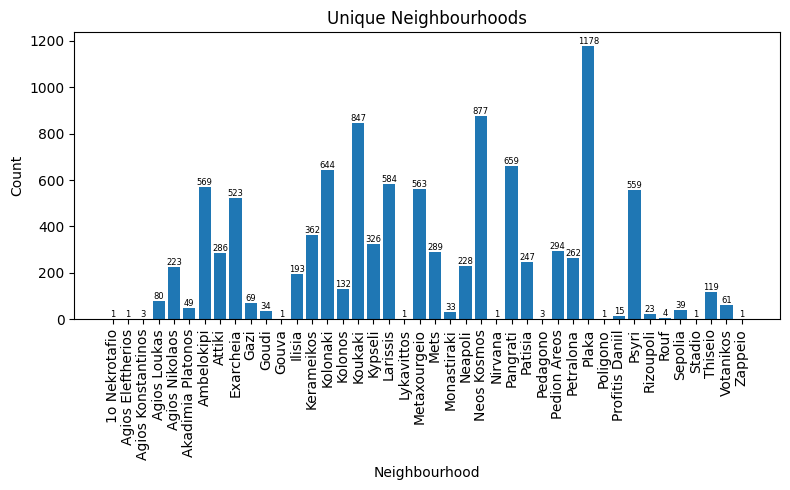


Graph of 2023


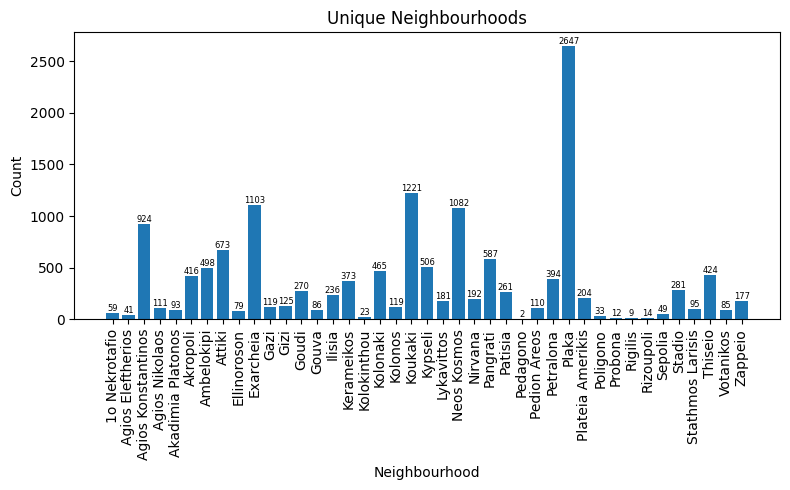

In [17]:
# Question 1.6
# Group the data by 'neighbourhood' and 'month' and count the number of unique neighborhoods

def mk_graph(df):
    temp_df = df.copy()

    temp_df.drop_duplicates(subset=['id'], inplace = True)
    properties = temp_df.groupby(['neighbourhood','month'], observed=False)['id'].count()

    neighborhood_total_counts = properties.groupby('neighbourhood', observed=False).sum()
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.bar(neighborhood_total_counts.index.get_level_values('neighbourhood'), neighborhood_total_counts)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # Set labels and title
    plt.xlabel('Neighbourhood')
    plt.ylabel('Count')
    plt.title('Unique Neighbourhoods')

    for i, count in enumerate(neighborhood_total_counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=6)

    # Show the plot
    plt.tight_layout()
    plt.show()

# 2019
print("Graph of 2019")
mk_graph(df_combined_2019)

# 2023
print("\nGraph of 2023")
mk_graph(df_combined_2023)

In [20]:
# Question 1.7
## NOMIZO META THA THELEI KAPOS NA EPANAFEREIS TA DIPLA STO DF ISOS KSANADIABAZONTAS TO ARXEIO KAI PERNONTAS TO STO IDIO df_combined

def find_roomtypes(df):

    df.drop_duplicates(subset=['id'])
    room_type_counts = df.groupby('neighbourhood', observed=False)['room_type'].value_counts()


    most_common_room_type = room_type_counts.groupby('neighbourhood', observed=False).nlargest(1).reset_index(level=1, drop=True)
    # result = room_type_counts.groupby('neighbourhood').idxmax()
    # result = result.reset_index(level = 0, drop = True)
    # print(result)
    print(most_common_room_type)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Year 2019
print("Year 2019:")
find_roomtypes(df_combined_2019)

# Year 2023
print("\nYear 2023")
find_roomtypes(df_combined_2023)

Year 2019:
neighbourhood       room_type      
1o Nekrotafio       Entire home/apt       2
Agios Eleftherios   Entire home/apt       1
Agios Konstantinos  Entire home/apt      13
Agios Loukas        Entire home/apt     177
Agios Nikolaos      Entire home/apt     526
Akadimia Platonos   Entire home/apt      96
Akropoli            Entire home/apt       7
Ambelokipi          Entire home/apt    1397
Attiki              Entire home/apt     662
Ellinoroson         Entire home/apt       2
Exarcheia           Entire home/apt    1187
Gazi                Entire home/apt     241
Gizi                Entire home/apt       2
Goudi               Entire home/apt      67
Gouva               Entire home/apt       4
Ilisia              Entire home/apt     476
Kerameikos          Entire home/apt     691
Kolokinthou         Entire home/apt       1
Kolonaki            Entire home/apt    1627
Kolonos             Entire home/apt     324
Koukaki             Entire home/apt    2116
Kypseli             Entire ho

In [22]:
# Question 1.8

def find_most_expensive_roomtype(data):
    df = pd.DataFrame(data)

    most_expensive = df.groupby('room_type')['price'].value_counts()

    result0 = 0
    result1 = 0
    result2 = 0


    for price_count  in most_expensive.items():
        if price_count[0][0] == 'Entire home/apt':
            result0 = result0 +  price_count[0][1] * price_count[1]

        if price_count[0][0] == 'Shared room':
            result1 = result1 +  price_count[0][1] * price_count[1]
        
        if price_count[0][0] == 'Private room':
            result2 = result2 +  price_count[0][1] * price_count[1]

    if result0 > result1:
        if result0 > result2:
            print('Entire home/apt',result0,'$')
        elif result0 < result2:
            print('Private room',result2,'$')
    elif result1 > result0:
        print('Shared room',result1,'$')
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2019
print("The most expensive room type for 2019:")
new_file_path = 'data_train/train_2019.csv'
data_from_2019 = pd.read_csv(new_file_path)
find_most_expensive_roomtype(data_from_2019)

# 2023
print("\nThe most expensive room type for 2023:")
new_file_path = 'data_train/train_2023.csv'
data_from_2023 = pd.read_csv(new_file_path)
find_most_expensive_roomtype(data_from_2023)


The most expensive room type for 2019:
Entire home/apt 1561879.0 $

The most expensive room type for 2023:
Entire home/apt 3448772.0 $


In [23]:
# Question 1.9
def folium_map(df):

    sample_df = df.sample(n=350)

    latitude = sample_df['latitude']
    longitude = sample_df['longitude']
    room_type = sample_df['room_type']

    center_latitude = latitude.mean()
    center_longitude = longitude.mean()

    # Create the Folium map with a starting zoom level
    map = folium.Map(location=[center_latitude, center_longitude], zoom_start=12.5)

    for i in range(len(latitude)):
        lat = latitude.iloc[i]
        lon = longitude.iloc[i]
        label = str(room_type.iloc[i])
        folium.Marker([lat, lon], popup=label).add_to(map)

    # Display the map
    display(map)


# Year 2019
# print("Year 2019:")
# folium_map(df_combined_2019)

# Year 2023
print("\nYear 2023:")
folium_map(df_combined_2023)


Year 2023:


Year 2019:
wordcloud - neighbourhood


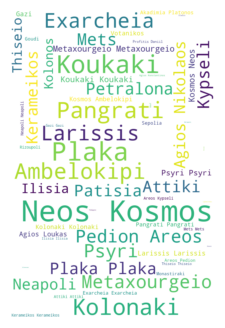

wordcloud - transit


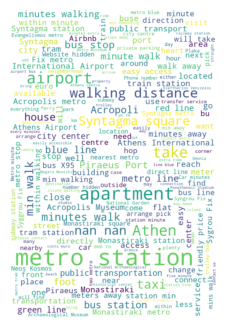

wordcloud - description


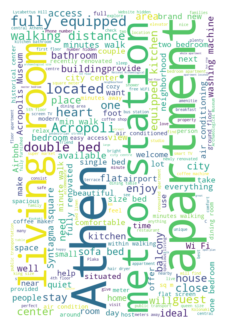

wordcloud - comments


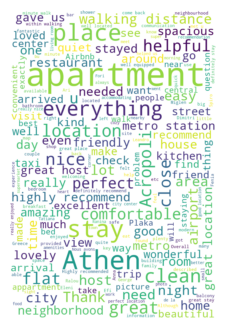

Year 2023:
wordcloud - neighbourhood


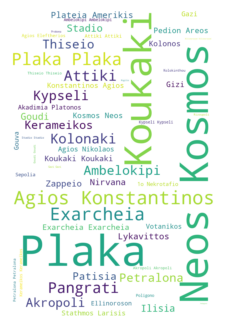

wordcloud - description


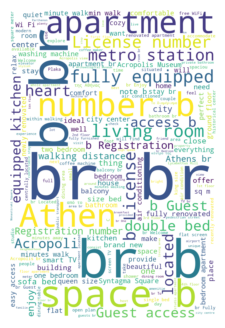

wordcloud - comments


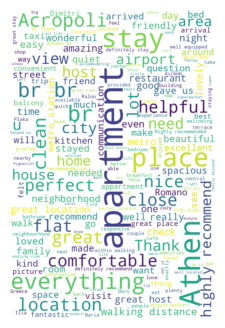

In [24]:
# Question 1.10

def wc_create(df, suffix=''):

    stopwords = STOPWORDS

    wc = WordCloud(
        background_color = 'white',
        stopwords=stopwords,
        height = 1080,
        width = 720
    )
    
    if 'neighbourhood' in df.columns:
        neighbourhood_text = ' '.join(df['neighbourhood'].astype(str))
        wc.generate(neighbourhood_text)
        plt.figure(figsize=(5, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        print("wordcloud - neighbourhood")
        plt.show()
        wc.to_file(f'wordclouds/neighbourhood_{suffix}.png')
        
    if 'transit' in df.columns:
        transit_text = ' '.join(df['transit'].astype(str))
        wc.generate(transit_text)
        plt.figure(figsize=(5, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        print("wordcloud - transit")
        plt.show()
        wc.to_file(f'wordclouds/transit_{suffix}.png')
        
    if 'description' in df.columns:
        description_text = ' '.join(df['description'].astype(str))
        wc.generate(description_text)
        plt.figure(figsize=(5, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        print("wordcloud - description")
        plt.show()
        wc.to_file(f'wordclouds/description_{suffix}.png')

    if 'comments' in df.columns:
        review_text = ' '.join(df['comments'].astype(str))
        wc.generate(review_text)
        plt.figure(figsize=(5, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        print("wordcloud - comments")
        plt.show()
        wc.to_file(f'wordclouds/review_{suffix}.png')

# Year 2019
print("Year 2019:")
wc_create(df_combined_2019, suffix='2019')

# Year 2023
print("Year 2023:")
wc_create(df_combined_2023, suffix='2023')

Year 2019:


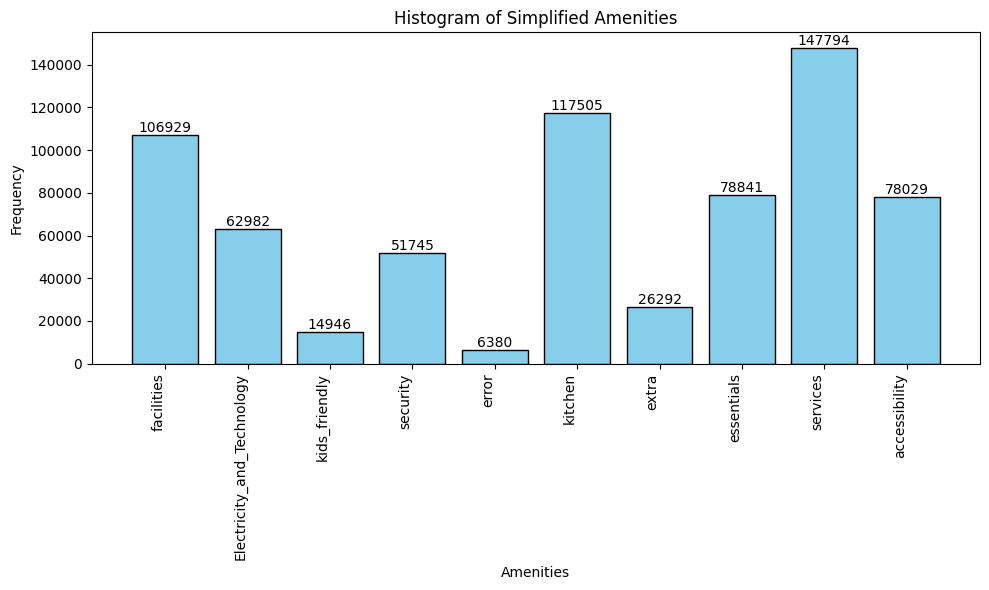

Year 2023:


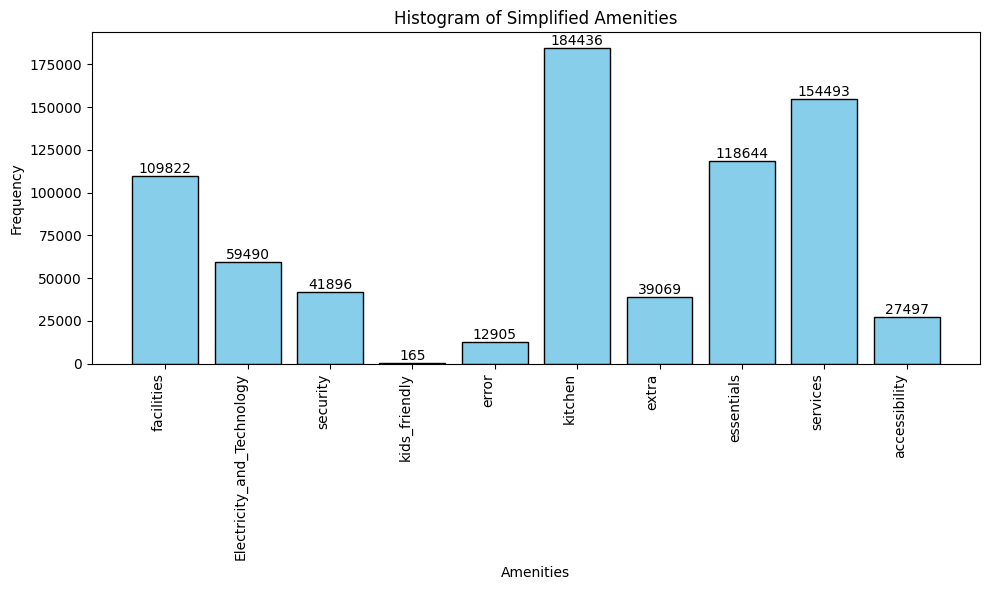

In [25]:
# Question 1.11 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def clean_amenities(df):

    
    categories = {
        "kitchen": ["Kitchen", "Microwave", "Coffee maker", "Refrigerator", "Dishwasher", "Dishes and silverware", "Cooking basics", "Oven", "Stove",\
                    "Full kitchen", "BBQ grill"],
        "accessibility": ["Elevator", "Buzzer/wireless intercom","Patio or balcony", "Wide doorway", "Step-free access", "Wide clearance to bed", "Accessible-height bed",\
                          "Wide hallway clearance", "Flat path to front door", "Wide entryway", "Flat path to front door", "Well-lit path to entrance",\
                            "Accessible-height toilet", "Wide clearance to shower", "Wheelchair accessible"],
        "Electricity_and_Technology": ["TV", "Cable TV", "Internet", "Wifi", "Ethernet connection", "Pocket wifi"],
        "facilities": ["Air conditioning", "Heating", "Hot water", "Washer", "Dryer", "High chair", "Bathtub", "Indoor fireplace", "Private living room", "Crib",\
                       "Hot tub", "toilet"],
        "kids_friendly": ["Family/kid friendly", "Children’s books and toys", "Game console"],
        "security": ["First aid kit", "Safety card", "Fire extinguisher", "Smoke detector", "Carbon monoxide detector", "Lock on bedroom door"],
        "essentials": ["Essentials", "Shampoo", "Extra pillows and blankets","Bed linens","Room-darkening shades","Handheld shower head"],
        "services": ["24-hour check-in", "Hangers", "Hair dryer", "Iron", "Laptop friendly workspace", "Luggage dropoff allowed", "Host greets you", "Pack ’n Play/travel crib",\
                     "Long term stays allowed","Free parking on premises", "Breakfast", "Free street parking", "Building staff", "Doorman"],
        "extra": ["Cleaning before checkout","Other", "Single level home", "Self check-in", "Smoking allowed", "Pets allowed",  "Paid parking off premises",  "Paid parking on premises"],
        "error": ["translation missing: en.hosting_amenity_49", "translation missing: en.hosting_amenity_50", "Lockbox"]
    }
    # amenities_list = []
    # for amenity_str in df['amenities']:
    # # Remove curly braces at the beginning and end (optional)
    #     amenity_str = amenity_str[1:-1]  # Assuming curly braces exist
    #     amenities = amenity_str.split(",")  # Split by commas
    #     for amenity in amenities:
    #         amenities_list.append(amenity.strip())  # Remove leading/trailing spaces

    # amenities_list = [amenity.strip('"') for amenity in amenities_list]
    # print(amenities_list[:20])  # Print the first 10 extracted amenities

    # simplified_amenities = []
    # for amenity in amenities_list:
    #     simplified_list = []
    #     for category, types in categories.items():
    #         if amenity in types:
    #                 simplified_list.append(category)
    #                 break
    #     simplified_amenities.append(simplified_list)

    #display(simplified_amenities)
        # Display the amenities_list and simplified_amenities with index

    #display(amenities_list, simplified_amenities)


    #display(simplified_amenities)

############################ TEST #################################################################
    # seen = set()

    # # Use list comprehension to iterate over the list of lists and remove duplicates
    # result = [x for lst in simplified_amenities for x in lst if not (x in seen or seen.add(x))]

    # print(len(result))


############################ TEST #################################################################

## PROBABLY CORRECT
    
    simplified_amenities_list = []
    for amenity_str in df['amenities']:
        amenity_list = amenity_str[1:-1].split(",")  # Assuming curly braces exist
        simplified_list = []
        for amenity in amenity_list:
            amenity = amenity.strip().strip('"')  # Remove leading/trailing spaces and quotes
            for category, types in categories.items():
                if amenity in types:
                    simplified_list.append(category)
                    break
        simplified_amenities_list.append(simplified_list)

    df['simplified_amenities'] = simplified_amenities_list


    # prepei meta na ginei amenities = simplified_amenities
    # an thes boroume na vgaloume ta duplicates apo ta simplified amenities ( den nomizo na prepei)
    # na ftiaxo liga ta diagrammata
    # print(df['simplified_amenities'])

    # Flatten the list of lists
    flattened_amenities = [item for sublist in df['simplified_amenities'] for item in sublist]
    
    # Count the frequency of each amenity category
    category_counts = {category: flattened_amenities.count(category) for category in set(flattened_amenities)}

    # Plot the histogram with annotations
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.keys(), category_counts.values(), color='skyblue', edgecolor='black')

    # Annotate each bar with its frequency
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height}', ha='center', va='bottom')
    # Plot the histogram
    # plt.hist(flattened_amenities, bins=len(set(flattened_amenities)), color='skyblue', edgecolor='black')
    plt.xlabel('Amenities')
    plt.ylabel('Frequency')
    plt.title('Histogram of Simplified Amenities')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

    # print(df['amenities'])

# Year 2019
print("Year 2019:")
clean_amenities(df_combined_2019)

# Year 2023
print("Year 2023:")
clean_amenities(df_combined_2023)

In [26]:
# Question 1.12
def gather_prices(df):
    temp_df = df.copy()
    temp_df = temp_df.drop(temp_df[temp_df['accommodates'] != 2].index)
    average_price = temp_df.groupby('neighbourhood')['price'].mean()
    print(average_price)

    ##### diatrexei ta meri kai ftiaxnei mia stili me to pou anoikoin(akriva,metria,ftina) eukolo einai
    # for i in range(len(average_price)):
    #     lat = latitude.iloc[i]
    #     lon = longitude.iloc[i]
    #     label = str(room_type.iloc[i])
    ################################################# graph
    # plt.figure(figsize=(12, 6))
    # average_price.plot(kind='bar')
    # plt.title('Average Price by Neighborhood')
    # plt.xlabel('Neighborhood')
    # plt.ylabel('Average Price')
    # plt.xticks(rotation=90, ha='right')
    # plt.tight_layout()
    # plt.show()
    ################################################# graph

# Year 2019
print("Year 2019:")
gather_prices(df_combined_2019)

# Year 2023
print("Year 2023:")
gather_prices(df_combined_2023)

Year 2019:
neighbourhood
1o Nekrotafio         65.000000
Agios Konstantinos    43.500000
Agios Loukas          32.379310
Agios Nikolaos        25.988889
Akadimia Platonos     37.617647
Akropoli              71.333333
Ambelokipi            33.841689
Attiki                28.301370
Ellinoroson           30.000000
Exarcheia             34.643875
Gazi                  35.912281
Goudi                 41.348837
Gouva                 29.000000
Ilisia                40.320000
Kerameikos            43.561151
Kolonaki              52.183544
Kolonos               36.933333
Koukaki               68.547009
Kypseli               27.820084
Larissis              31.936986
Lykavittos            45.500000
Metaxourgeio          46.528302
Mets                  38.740196
Monastiraki           77.470588
Neapoli               33.647343
Neos Kosmos           96.338346
Nirvana               20.000000
Pangrati              35.865196
Patisia               28.601266
Pedagono              60.000000
Pedion Areos   

In [27]:
# Question 1.13

###
# Number of reviews for each apartment and its review score rating
# Group by id so we dont count the same apartment in each month

def review_stats(df):
    reviews = df.groupby('id').agg({'number_of_reviews': 'count', 'review_scores_rating': 'mean'}).dropna()
    # print(reviews)
    return reviews

# Year 2019
print("Number of reviews and review score rating of each apartment for the year 2019:")
print("Disclaimer: Review score rating up to 100")
reviews_2019 = review_stats(df_combined_2019)

# Year 2023
print("Number of reviews and review score rating of each apartment for the year 2019:")
print("Disclaimer: Review score rating up to 5")
reviews_2023 = review_stats(df_combined_2023)

###
# See the average difference of review scores between years 2019 and 2023
# Merge the DataFrames on 'listing_id'

# Calculate the total number of reviews and the total score rating for all apartments in 2019
total_reviews_2019 = reviews_2019['number_of_reviews'].sum()
total_score_rating_2019 = reviews_2019['review_scores_rating'].sum()
average_2019 = total_score_rating_2019/total_reviews_2019


# Calculate the total number of reviews and the total score rating for all apartments in 2019
total_reviews_2023 = reviews_2023['number_of_reviews'].sum()
total_score_rating_2023 = reviews_2023['review_scores_rating'].sum()
average_2023 = total_score_rating_2023/total_reviews_2023

print("\nTotal score rating for all apartments in 2019:", total_score_rating_2019)
print("Total score rating for all apartments in 2023:", total_score_rating_2023)


print("\nTotal number of reviews made in 2019:", total_reviews_2019)
print("Total number of reviews made in 2023:", total_reviews_2023)

# Format the avarage review score to display only the first three decimal places
average_2019 = "{:.3f}".format(average_2019)
average_2023 = "{:.3f}".format(average_2023)

print("\nAverage review score of 2019 is:", average_2019)
print("Average review score of 2023 is:", average_2023)

###
# Function that returns the most common property type of a year
def most_common_property_type(df_combined):
    result = df_combined['property_type'].value_counts()
    print(result)

# Year 2019
print("For 2019 the number of different property types is:")
room_type = most_common_property_type(df_combined_2019)

# Year 2023
print("\nFor 2023 the number of different property types is:")
room_type = most_common_property_type(df_combined_2023)



Number of reviews and review score rating of each apartment for the year 2019:
Disclaimer: Review score rating up to 100
Number of reviews and review score rating of each apartment for the year 2019:
Disclaimer: Review score rating up to 5

Total score rating for all apartments in 2019: 734602.1666666666
Total score rating for all apartments in 2023: 56696.495

Total number of reviews made in 2019: 21764
Total number of reviews made in 2023: 31700

Average review score of 2019 is: 33.753
Average review score of 2023 is: 1.789
For 2019 the number of different property types is:
property_type
Apartment                  24099
House                       1053
Serviced apartment           591
Loft                         486
Condominium                  478
Hotel                        356
Bed and breakfast            204
Aparthotel                   197
Boutique hotel               146
Other                        104
Townhouse                    103
Hostel                        66
Guesth

In [29]:
# Question 1.14

def top_hosts(df):
    # Group by host_id and count number of properties for each host
    host_listings_count = df.groupby(['host_id','host_name'])['id'].count().reset_index()

    # Sort results based on number of properties
    host_listings_count_sorted = host_listings_count.sort_values(by='id', ascending=False)

    # Top 10 hosts with the most properties
    top_10_hosts = host_listings_count_sorted.head(10)
    
    # Rename the 'listing_id' column to 'property_count'
    top_10_hosts.rename(columns={'id': 'property_count'}, inplace=True)

    # Results
    print(top_10_hosts.to_string(index=False))

# Year 2019
print("Top 10 hosts for 2019:")
top_hosts(df_combined_2019)

#Year 2023
print("\nTop 10 hosts for 2023:")
top_hosts(df_combined_2023)

Top 10 hosts for 2019:
  host_id                     host_name  property_count
 77457889                    Παναγιώτης             272
 29927830 Dimitris, Konstantinos & Sevi             259
   748818                        George             226
135482892                          Home             224
  1621474                  Eazybnb Team             195
  1418201                          Dean             188
112527018                          Toni             169
 65714690                          Home             133
  2089542                    Tia & Mike             130
 55670751                            Jj             126

Top 10 hosts for 2023:
  host_id   host_name  property_count
 20104194    Upstreet             333
113548208         Mgv             229
 90390850 Evan&Anetta             223
   748818      George             212
 29927830      Homm ®             203
  2089542  Tia & Mike             173
 47267002         Tèo             166
182156346    Maryland            